# Testing the ALeRCE forecasting tool (under construction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

# Load the ALeRCE client 
https://alerce-new-python-client.readthedocs.io/en/main/tutorials/ztf_api.html#usage

In [2]:
my_config = {
    "ZTF_API_URL": "https://dev.api.alerce.online"
}
from alerce.core import Alerce
alerce = Alerce()
alerce.load_config_from_object(my_config)

# Select a SN

In [3]:
oid = "ZTF21aaqftuq" #"ZTF21aaqftuq"

# Check in ALeRCE explorer

In [4]:
from IPython.core.display import display, HTML
display(HTML("<a href=\"https://dev.alerce.online/object/%s\">%s</a>" % (oid, oid)))

# Query object statistics

In [5]:
alerce.query_objects(oid=oid, format='pandas')

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF21aaqftuq,7,1665,59292.535938,59297.534907,True,True,7,None,None,...,59297.534907,4.99897,334.844817,32.957895,0.000044,0.00002,None,None,None,correction_0.0.1


# Query object band dependent statistics

In [6]:
alerce.query_magstats(oid=oid, format='pandas')

,fid,stellar,corrected,ndet,ndubious,magmean,magmedian,magmax,magmin,magsigma,maglast,magfirst,firstmjd,lastmjd,step_id_corr
0,2,True,True,7,0,17.168188,16.861237,18.233017,16.391235,0.724354,16.391235,18.164976,59292.535,59297.535,correction_0.0.1


# Get light curve

In [7]:
# Getting detections for an object
det = alerce.query_detections(oid, format="pandas")
display(det)

# Getting non detections for an object
non_det = alerce.query_non_detections(oid, format="pandas")
display(non_det)
non_det

,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,magpsf_corr,...,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,candid_alert,step_id_corr,phase,parent_candid
0,59292.535938,1538535932815015004,2,1538535932815,19.374205,1,1538,0.492556,18.164976,17.130201,...,18.0665,0.1522,691120228.0,True,True,False,None,correction_0.0.1,None,None
1,59292.538380,1538538372815015004,2,1538538372815,19.201283,1,1538,0.527174,18.233017,17.155933,...,18.7859,0.3522,691120228.0,True,True,False,None,correction_0.0.1,None,None
2,59295.529502,1541529502815015004,2,1541529502815,19.185300,1,1541,0.502194,16.808800,16.400148,...,16.7748,0.0387,NaN,False,True,False,None,correction_0.0.1,None,None
3,59295.531910,1541531902815015016,2,1541531902815,19.189621,1,1541,0.682880,16.861237,16.435863,...,16.8332,0.0449,691120228.0,True,True,False,None,correction_0.0.1,None,None
4,59295.534317,1541534312815015005,2,1541534312815,18.997221,1,1541,0.564532,16.823713,16.410362,...,16.8249,0.0502,691120228.0,True,True,False,None,correction_0.0.1,None,None
5,59295.536713,1541536712815015007,2,1541536712815,18.869886,1,1541,0.536552,16.894344,16.458128,...,16.8470,0.0613,691120228.0,True,True,False,None,correction_0.0.1,None,None
6,59297.534907,1543534902815015005,2,1543534902815,18.966776,1,1543,0.651163,16.391235,16.097149,...,16.3878,0.0349,691120228.0,True,True,False,None,correction_0.0.1,None,None


""


""


# Plot stamps

In [8]:
#alerce.get_stamps(oid, candid=None)#candid=det.loc[det.has_stamp].candid.min())
alerce.plot_stamps(oid, candid=det.loc[det.has_stamp].candid.min())

# Plot light curve

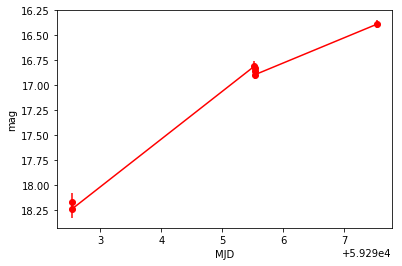

In [9]:
fig, ax = plt.subplots()
colors = {1: 'g', 2: 'r'}
for fid in det.fid.unique():
    mask = det.fid == fid
    ax.errorbar(det.loc[mask].mjd, det.loc[mask].magpsf, yerr=det.loc[mask].sigmapsf, c=colors[fid], marker='o')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD")
ax.set_ylabel("mag")

# Forecasting

In [10]:
times = np.linspace(det.mjd.min() - 10, det.mjd.max() + 30, 10)

In [12]:
forecasts = []
for mjd in times:
    response = requests.get("http://3.238.105.175:8081/parametric/sn?oid=%s&mjd=%s" % (oid, mjd))
    forecasts += response.json()["forecast"]

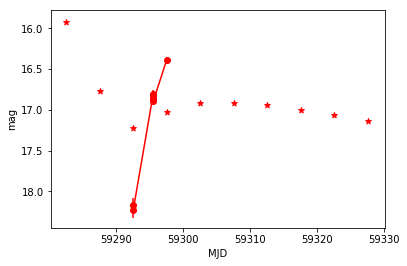

In [13]:
fig, ax = plt.subplots()
colors = {1: 'g', 2: 'r'}
for fid in det.fid.unique():
    mask = det.fid == fid
    ax.errorbar(det.loc[mask].mjd, det.loc[mask].magpsf, yerr=det.loc[mask].sigmapsf, c=colors[fid], marker='o')    
for i in forecasts:
    if not i["magpsf"] is None:
        ax.scatter(i["mjd"], i["magpsf"], c=colors[fid], marker='*')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD")
ax.set_ylabel("mag")